In [21]:
from itertools import permutations, combinations
import random
from tabulate import tabulate
from math import factorial
import datetime
import itertools

#### Helper functions

In [22]:
def get_combinations(players: [str], length: int) -> list:
    """Get all combinations of a list of players of a given length"""
    return list(combinations(players, length))

def get_permutations(players: [str], length: int) -> list:
    """Get all permutations of a list of players of a given length"""
    return list(permutations(players, length))

def get_all_combinations(players: [str]) -> list:
    """Get a list of all combinations of all lengths of a list of players"""
    combinations = []
    for i in range(len(players)):
        combinations += get_combinations(players=players, length=i+1)
    return combinations

def get_all_permutations(players:[str]) -> int:
    """Get all permutations that contain all players"""
    return get_permutations(players=players, length=len(players))

def assign_random_value(combinations: list, value_range:int = 20) -> dict:
    """To each of the given player combinations assign a random value."""
    comb_dict = {}
    for comb in combinations:
        comb_dict[comb] = random.randint(value_range*len(comb)-value_range, value_range*len(comb))
    return comb_dict

def create_player_list(no_players: int) -> list:
    """Create a list with consecutive letters/characters of given length"""
    players = []
    for i in range(no_players):
        players += chr(ord('A') + i)
    return list(players)

def table(valued_sub_sets: dict, head: list) -> str:
    """Create a table for better representation"""
    data = []
    for key, value in valued_sub_sets.items():
        data.append([key, value])
    return tabulate(data, headers=head, tablefmt="grid")

def is_matching_subset(sub_set1: list, sub_set2: list) -> bool:
    """Checks if two sub sets are matching"""
    return len(sub_set1) is len(sub_set2) is len(set(sub_set1).intersection(sub_set2))

def get_sub_set_value(comb: dict, sub_set: list) -> int:
    """Get a sub sets value out of the given combination dictionary"""
    for c in comb:
        if is_matching_subset(c, sub_set):
            return comb[c]


In [23]:
def shapley_sequence_definition(valued_sub_sets:dict, players: list) -> dict:
    """Calculate Shapley values by sequence definition"""
    shapley_dict = {players[i]: 0 for i in range(0, len(players))}
    
    permutations = get_all_permutations(players)
    
    for perm in permutations:
        perm_players = []
        perm_value = 0
        for player in perm:
            perm_players.append(player)
            sub_set_value = get_sub_set_value(valued_sub_sets, perm_players)
            shapley_dict[player] += sub_set_value - perm_value
            perm_value = sub_set_value
            
    return {player: value/factorial(len(players)) for player, value in shapley_dict.items()}


def shapley_sub_set_definition(valued_sub_sets:dict, players: list) -> dict:
    """Calculate Shapley values by sub set definition"""
    shapley_dict = {players[i]: 0 for i in range(0, len(players))}   

    for player in players:
        # manual adding values for empty set
        freq = factorial(len(players) - 1)
        marg_contrib = get_sub_set_value(valued_sub_sets, (player,))
        shapley_dict[player] += freq*marg_contrib
        
        for sub_set in valued_sub_sets:
            if not player in sub_set:
                freq = factorial(len(players) - 1 - len(sub_set)) * factorial(len(sub_set))
                marg_contrib = get_sub_set_value(valued_sub_sets, sub_set + (player,)) - get_sub_set_value(valued_sub_sets, sub_set)
                shapley_dict[player] += freq*marg_contrib
    return {player: value/factorial(len(players)) for player, value in shapley_dict.items()}


##### Example: Calculate shap values for each feature

In [4]:
# Define feature and metric table
feature_metric_sub_sets = {('feature1',): 13,
 ('feature2',): 4,
 ('feature3',): 15,
 ('feature1', 'feature2'): 30,
 ('feature1', 'feature3'): 36,
 ('feature2', 'feature3'): 24,
 ('feature1', 'feature2', 'feature3'): 46,
 }

features = ['feature1', 'feature2', 'feature3']

print(table(feature_metric_sub_sets, ['Feature', 'Metric']))

+--------------------------------------+----------+
| Feature                              |   Metric |
+======================================+==========+
| ('feature1',)                        |       13 |
+--------------------------------------+----------+
| ('feature2',)                        |        4 |
+--------------------------------------+----------+
| ('feature3',)                        |       15 |
+--------------------------------------+----------+
| ('feature1', 'feature2')             |       30 |
+--------------------------------------+----------+
| ('feature1', 'feature3')             |       36 |
+--------------------------------------+----------+
| ('feature2', 'feature3')             |       24 |
+--------------------------------------+----------+
| ('feature1', 'feature2', 'feature3') |       46 |
+--------------------------------------+----------+


In [5]:
# Run Shapley value calculation by sequence definition
shap_values = shapley_sequence_definition(valued_sub_sets=feature_metric_sub_sets, players=features)
print(table(shap_values, ['Player', 'Value']))


+----------+---------+
| Player   |   Value |
+==========+=========+
| feature1 |    19.5 |
+----------+---------+
| feature2 |     9   |
+----------+---------+
| feature3 |    17.5 |
+----------+---------+


#### Descriptive statistics of metric values for all logs/miners 

In [24]:
benchmark_results_path = '../data/genTriangle_benchmark.csv'
shape_results_path = '../data/genTriangle_shap.csv'

In [25]:
import pandas as pd

df = pd.read_csv(benchmark_results_path)

# Identify all unique miners
miners = set()
for col in df.columns:
    if '_' in col:
        miner = col.split('_')[-1]
        miners.add(miner)

# Calculate the average metric values for each miner
average_metrics = {}
for miner in miners:
    miner_columns = [col for col in df.columns if col.endswith(miner)]
    average_metrics[miner] = df[miner_columns].mean()

# Display the results
for miner, averages in average_metrics.items():
    print(f"Average metric values for {miner} miners:")
    print(averages)
    print()

Average metric values for ilp miners:
fitness_ilp       0.999974
precision_ilp     0.566916
fscore_ilp        0.669284
size_ilp         42.507937
pnsize_ilp       18.126984
cfc_ilp          12.888889
exectime_ilp      4.289524
benchtime_ilp    74.176667
dtype: float64

Average metric values for sm miners:
fitness_sm       0.793608
precision_sm     0.790562
fscore_sm        0.763486
size_sm         24.873016
pnsize_sm       15.365079
cfc_sm           9.714286
exectime_sm      9.154603
benchtime_sm    61.475397
dtype: float64

Average metric values for heuristics miners:
fitness_heuristics          0.557675
precision_heuristics        0.825242
fscore_heuristics           0.613362
size_heuristics            29.864407
pnsize_heuristics          17.355932
cfc_heuristics             12.949153
exectime_heuristics         0.235614
benchtime_heuristics    13158.168160
dtype: float64

Average metric values for inductive miners:
fitness_inductive          0.999903
precision_inductive        0.582

#### Shap values for each feature

In [26]:
import pandas as pd
import itertools
import numpy as np
import shap

def generate_permutations(log):
    parts = log.split('_')
    permutations = []
    for i in range(1, len(parts)+1):
        for combo in itertools.combinations(range(len(parts)), i):
            perm = ['nan'] * len(parts)
            for idx in combo:
                perm[idx] = parts[idx]
            permutations.append('_'.join(perm))
    return permutations

def clean_log(entry):
    return '_'.join([part for part in entry.split('_') if part != 'nan'])


def map_features(log_identifier):
    return tuple(log_identifier.split('_'))


data = pd.read_csv(benchmark_results_path)
metric_list = data.columns[1:]
# metric_name = 'fitness_heuristics'

# aggregating shap values
feature_names = ['mvo', 'rvpnot', 'tlcv']
mean_shap_values_dict = {}
shap_values_obj_dict ={}

for idx_loc,metric_name in enumerate(metric_list):
    print(f'Calculating Shapley values for metric: {metric_name}')
    data = pd.read_csv(benchmark_results_path)
    data.replace(-1,np.nan, inplace=True)
    data.iloc[:,1:]= data.iloc[:,1:].apply(lambda x: x.fillna(x.mean()), axis=0)
    data['log'] = data['log'].str.replace(r'00$', '000', regex=True)

    data = data [['log',metric_name]]
    # Step 1: Merge `genELtask` with the immediate number
    data['log'] = data['log'].str.replace(r'(genELtask)_(\d+)', r'\1\2', regex=True)

    # Step 2: Extract the text after the first `_`
    data['log'] = data['log'].str.split('_', n=1).str[1]

    # Step 2.5: Remove all the nan and its corresponding _ from the log
    data['log'] = data['log'].str.replace(r'(_nan)', r'', regex=True).str.replace(r'(nan_)', r'', regex=True)

    # Step 3: Identifying all logs with 3 features
    data_filtered = data[data['log'].str.count('_') == 2]
    data_filtered = data_filtered[~data_filtered['log'].str.contains('nan')].reset_index(drop=True)


    # Step 4: Find all permutations while maintaining order

    # Apply the permutation generation and store results
    data_filtered['permutations'] = data_filtered['log'].apply(generate_permutations)
    data_filtered['permutations'] = data_filtered['permutations'].apply(lambda x: [clean_log(entry) for entry in x])


    # Step 5: find all the permutations of the eligible logs and calculate the shapley values

    shap_values_list = []
    base_values_list = []
    data_values_list = []

    for idx in range(len(data_filtered)):
        features_names = data_filtered.loc[idx, 'permutations'][:3]
        features_metric_data = data[data['log'].isin(data_filtered.iloc[idx]['permutations'])].reset_index(drop=True)
        
        # appending missing permutations with 0 value. Please comment the line below when the whole dataset is used
        if len(features_metric_data) < 7:
            print('Missing permutations for log:')
            missing = list(set(data_filtered.iloc[idx]['permutations']) - set(features_metric_data['log']))
            missing_df = pd.DataFrame({'log': missing, metric_name: [0]*len(missing)})
            features_metric_data = pd.concat([features_metric_data, missing_df]).reset_index(drop=True)
            
        # Create the dictionary with feature tuples 
        features_metric_data_dict = {map_features(row['log']): row[metric_name] for index, row in features_metric_data.iterrows()}
        
        # calculate shap values
        shap_values = shapley_sequence_definition(valued_sub_sets=features_metric_data_dict, players=features_names)
        print(table(shap_values, ['Feature', 'Metric']))
        print('---')
        
        shap_values_list.append(list(shap_values.values()))
        base_values_list.append(0)
        data_values_list.append([int(num) for num in features_names])
        # break
    mean_shap_values = np.mean(shap_values_list, axis=0)
    mean_shap_values_dict[metric_name] = mean_shap_values
    shap_values_obj_dict[metric_name] = shap.Explanation(values=np.array(shap_values_list), base_values=np.array(base_values_list), data=np.array(data_values_list), feature_names=feature_names)


mean_shap_values_df = pd.DataFrame(mean_shap_values_dict, index=feature_names).T

Calculating Shapley values for metric: fitness_heuristics
+-----------+----------+
|   Feature |   Metric |
+===========+==========+
|       713 | 0.324627 |
+-----------+----------+
|       047 | 0.217339 |
+-----------+----------+
|       084 | 0.257974 |
+-----------+----------+
---
+-----------+------------+
|   Feature |     Metric |
+===========+============+
|       713 | -0.0111446 |
+-----------+------------+
|       047 |  0.012972  |
+-----------+------------+
|       101 |  0.367792  |
+-----------+------------+
---
+-----------+-----------+
|   Feature |    Metric |
+===========+===========+
|       713 | 0.19231   |
+-----------+-----------+
|       047 | 0.0696882 |
+-----------+-----------+
|       000 | 0.337992  |
+-----------+-----------+
---
+-----------+----------+
|   Feature |   Metric |
+===========+==========+
|       713 | 0.253424 |
+-----------+----------+
|       095 | 0.410772 |
+-----------+----------+
|       084 | 0.195042 |
+-----------+----------+
---

In [27]:
mean_shap_values_df["metric_miner"] = mean_shap_values_df.index
mean_shap_values_df = mean_shap_values_df.reset_index(drop=True)
mean_shap_values_df[['metric', 'miner']] = mean_shap_values_df['metric_miner'].str.split('_', expand=True)
mean_shap_values_df.drop(columns=['metric_miner'], inplace=True)
mean_shap_values_df.to_csv(shape_results_path, index=False)

#### Shap plots

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
mean_shap_values_df = pd.read_csv(shape_results_path)
mean_shap_values_df.replace("heuristics","heu", inplace=True)
mean_shap_values_df.replace("inductive","ind", inplace=True)
#select only the rows which dont have fitness and precision as value in the metric column

mean_shap_values_df = mean_shap_values_df[~mean_shap_values_df['metric'].isin([ 'pnsize'])]

##### Unnormalized

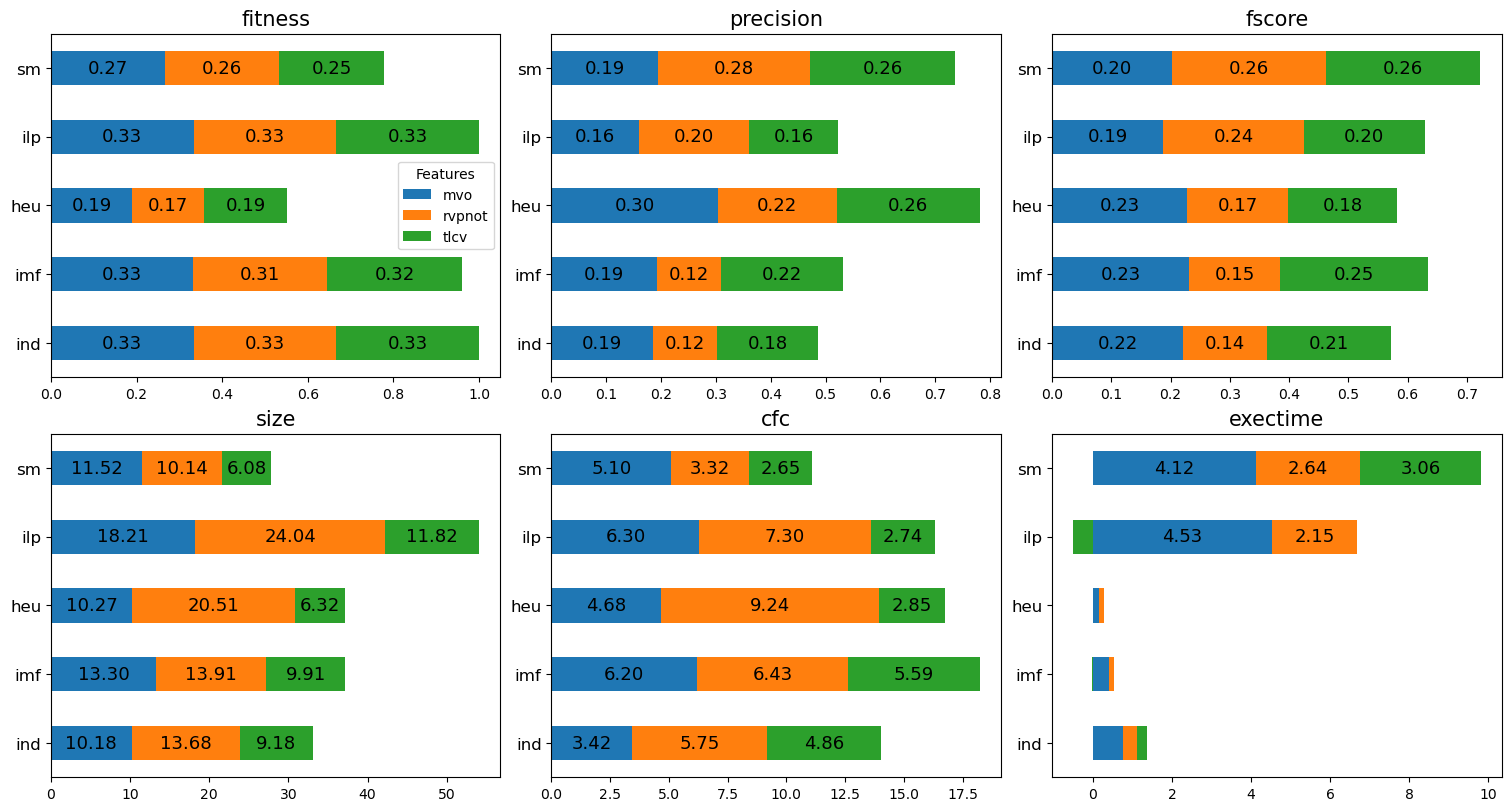

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Sample list of miners
miners = ["ind", "imf", "heu", "ilp", "sm"]
# Define the desired order of metrics
desired_metrics_order = ["fitness", "precision", "fscore", "size", "cfc", "exectime"]

# Get unique metrics
metrics = mean_shap_values_df['metric'].unique()

# Determine the number of plots and layout
num_metrics = len(desired_metrics_order)
num_cols = 3  # Number of columns you want in your grid layout
num_rows = int(np.ceil(num_metrics / num_cols))  # Calculate the required number of rows

# Create a figure with a grid layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows), constrained_layout=True)

# Flatten the axes array for easy iteration
axs = axs.flatten()

for i, metric in enumerate(desired_metrics_order):
    if metric in metrics:  # Check if the metric is in the DataFrame
        # Filter data for the current metric
        metric_mean_shap_values_df = mean_shap_values_df[mean_shap_values_df['metric'] == metric]
        
        # Pivot the DataFrame for the current metric
        pivot_mean_shap_values_df = metric_mean_shap_values_df.pivot_table(index='miner', values=['mvo', 'rvpnot', 'tlcv'], aggfunc='sum')
        
        # Reorder the DataFrame index based on the desired miners order
        pivot_mean_shap_values_df = pivot_mean_shap_values_df.reindex(miners)
        
        # Plot the stacked horizontal bar plot
        ax = pivot_mean_shap_values_df.plot(kind='barh', stacked=True, ax=axs[i])
        
        # Customize the plot
        axs[i].set_ylabel('')
        axs[i].set_xlabel('')
        axs[i].set_title(f'{metric}', fontsize=15)
        axs[i].tick_params(axis='y', rotation=0, labelsize=12)
        if i == 0:  # Show legend only for the first column of plots
            axs[i].legend(title='Features')
        else:
            axs[i].legend().remove()
        
        # Add values to the bars
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            if width > 0:
                miner = p.get_y() + height / 2
                if not (metric == "exectime" and miners[int(miner)] in ["heu", "imf", "ind"]):
                    ax.text(x + width / 2, y + height / 2, f'{width:.2f}', ha='center', va='center', fontsize=13, color='black')

    else:
        fig.delaxes(axs[i])  # Remove axes for missing metrics

# Show the plot
plt.show()


##### Normalized

In [31]:
def normalize_group(group):
    # Flatten the values within the group
    flat_values = group[['mvo', 'rvpnot', 'tlcv']].values.flatten()
    
    # Compute min and max for the group
    min_val = flat_values.min()
    max_val = flat_values.max()
    
    # Avoid division by zero
    if max_val == min_val:
        normalized_flat_values = flat_values
    else:
        # Normalize the values within the group
        normalized_flat_values = (flat_values - min_val) / (max_val - min_val)
    
    # Reshape back to original DataFrame shape
    normalized_values = normalized_flat_values.reshape(group[['mvo', 'rvpnot', 'tlcv']].shape)
    
    # Create a DataFrame with normalized values
    normalized_df = pd.DataFrame(normalized_values, columns=['mvo', 'rvpnot', 'tlcv'])
    
    # Add metric and miner columns
    normalized_df['metric'] = group['metric'].values
    normalized_df['miner'] = group['miner'].values
    
    return normalized_df

# Apply normalization within each group
normalized_df_list = []
for _, group in mean_shap_values_df.groupby('metric'):
    normalized_df_list.append(normalize_group(group))

# Concatenate all normalized DataFrames into a single DataFrame
mean_shap_values_df_normalized = pd.concat(normalized_df_list, ignore_index=True)

# Display the result
print(mean_shap_values_df_normalized)

         mvo    rvpnot      tlcv     metric miner
0   0.799641  0.779119  0.797612  benchtime   heu
1   0.000000  1.000000  0.979710  benchtime   ind
2   0.664233  0.663995  0.662079  benchtime   imf
3   0.658293  0.657012  0.656205  benchtime    sm
4   0.658321  0.657249  0.656430  benchtime   ilp
5   0.307747  1.000000  0.029503        cfc   heu
6   0.116169  0.470299  0.335392        cfc   ind
7   0.538689  0.572415  0.445941        cfc   imf
8   0.370993  0.101180  0.000000        cfc    sm
9   0.552741  0.704511  0.013116        cfc   ilp
10  0.131154  0.126300  0.104754   exectime   heu
11  0.250790  0.173472  0.152352   exectime   ind
12  0.184395  0.125105  0.095956   exectime   imf
13  0.917623  0.625026  0.708295   exectime    sm
14  1.000000  0.528325  0.000000   exectime   ilp
15  0.135460  0.000000  0.165264    fitness   heu
16  0.999888  0.999854  0.999744    fitness   ind
17  0.984642  0.883019  0.898195    fitness   imf
18  0.601968  0.587422  0.477224    fitness    sm


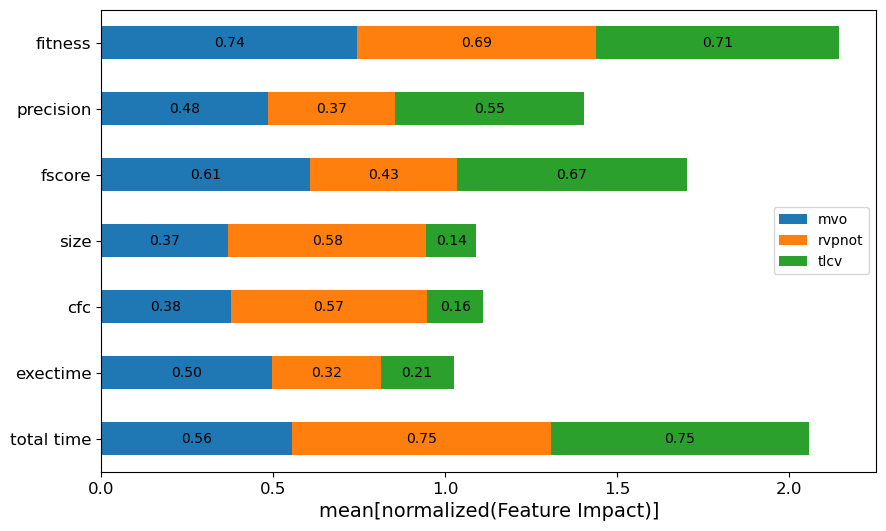

In [32]:
mean_shap_values_df_normalized['metric'] = mean_shap_values_df_normalized['metric'].replace({'benchtime': 'total time'})

# Aggregating by 'metric' and calculating mean values
mean_shap_values_df_normalized = mean_shap_values_df_normalized.groupby('metric')[['mvo', 'rvpnot', 'tlcv']].mean().reset_index()

# Ensure all desired metrics are present in the DataFrame, even if they have to be added as NaN
desired_order = ["total time","exectime","cfc","size","fscore","precision","fitness"]

# Create a DataFrame with the desired order and merge with the mean_shap_values_df_normalized
ordered_df = pd.DataFrame({'metric': desired_order})
mean_shap_values_df_normalized = ordered_df.merge(mean_shap_values_df_normalized, on='metric', how='left')

# Replace NaN with 0s if necessary
mean_shap_values_df_normalized.fillna(0, inplace=True)

# Plot the bar chart
ax = mean_shap_values_df_normalized.set_index('metric')[['mvo', 'rvpnot', 'tlcv']].plot(kind='barh', stacked=True, figsize=(10, 6))

# Add values on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center')

# Customize the plot
ax.set_xlabel('mean[normalized(Feature Impact)]', fontsize=14)
ax.set_ylabel('', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

##### Beeswarm Plots

time beeswarm

In [33]:
import matplotlib.pyplot as plt
order = ['mvo', 'rvpnot', 'tlcv']

col2num = {col: i for i, col in enumerate(['mvo', 'rvpnot', 'tlcv'])}

order = list(map(col2num.get, order))

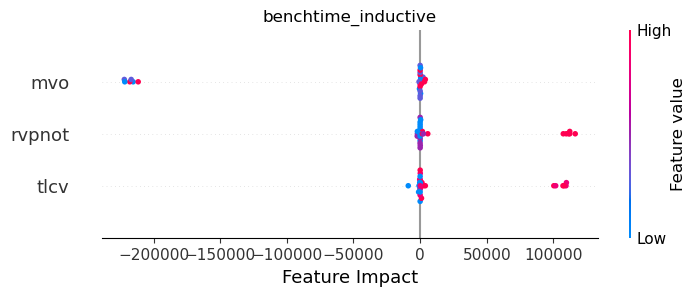

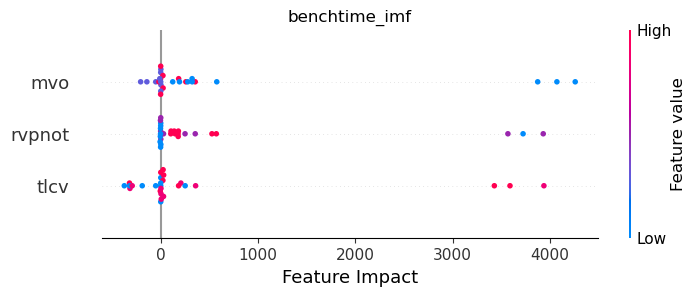

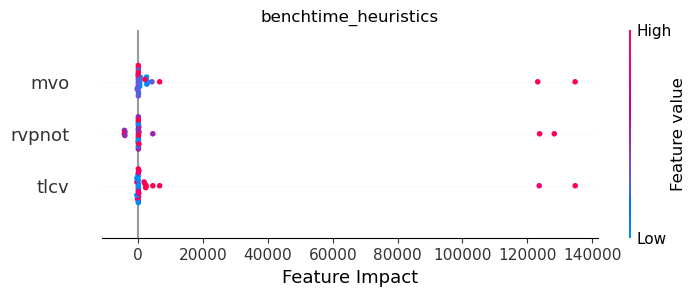

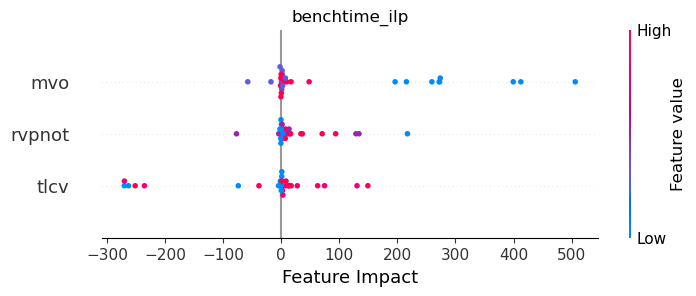

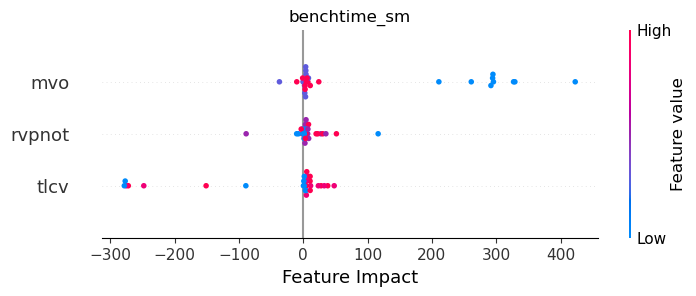

In [34]:
for mine in ["inductive", "imf", "heuristics", "ilp", "sm"]:
    shap.plots.beeswarm(shap_values_obj_dict[f'benchtime_'+ mine],show = False,order = order)
    plt.xlabel('Feature Impact') 
    plt.title(f'benchtime_{mine}')
    plt.show()

for exectime beesaerm

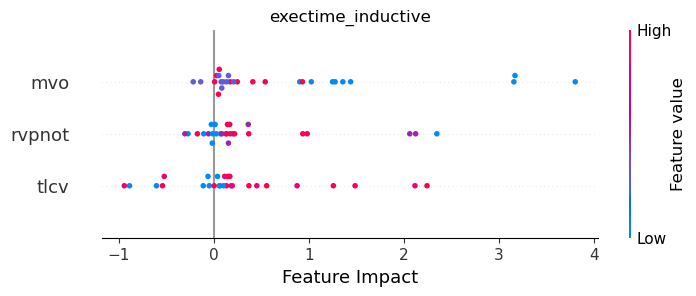

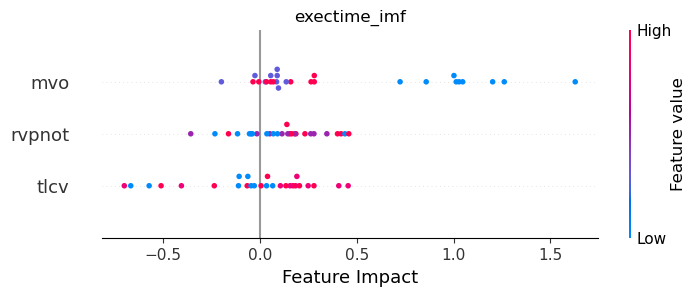

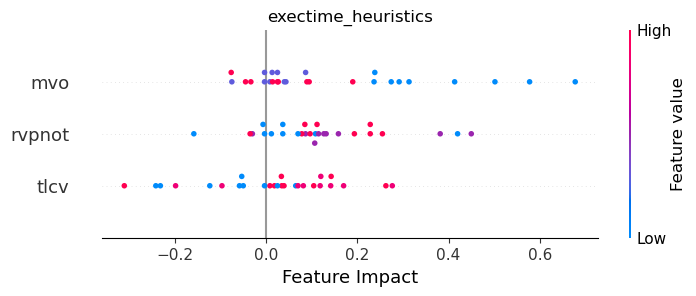

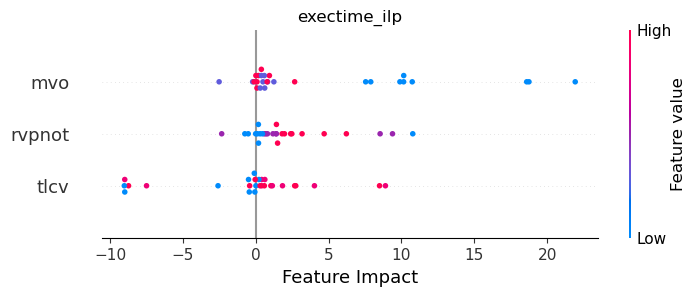

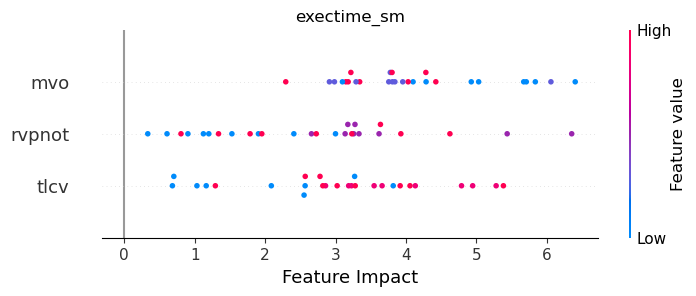

In [35]:
for mine in ["inductive", "imf", "heuristics", "ilp", "sm"]:
    shap.plots.beeswarm(shap_values_obj_dict[f'exectime_'+ mine],show = False,order = order)
    plt.xlabel('Feature Impact')
    plt.title(f'exectime_{mine}')
    plt.show()

for fitness beesewarm

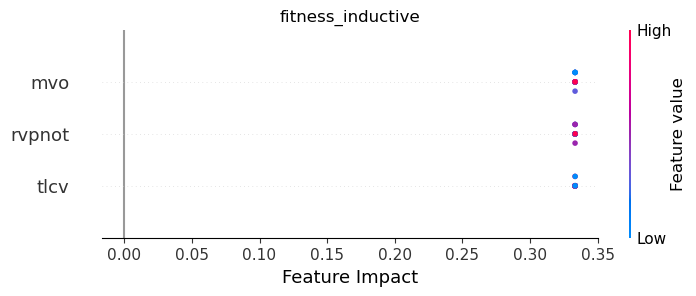

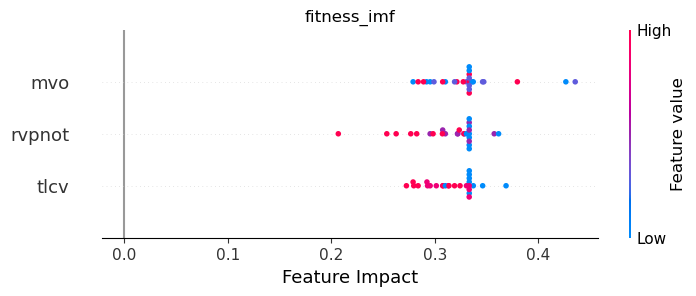

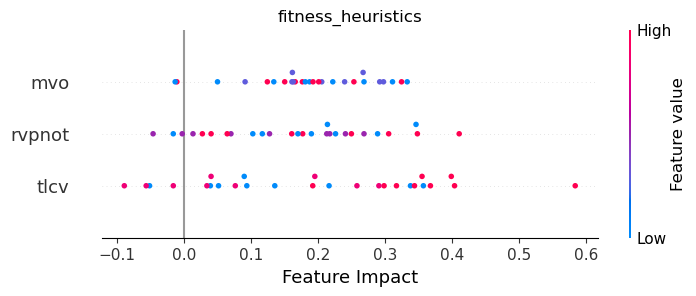

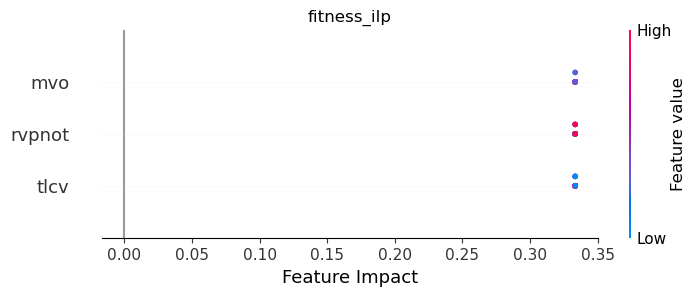

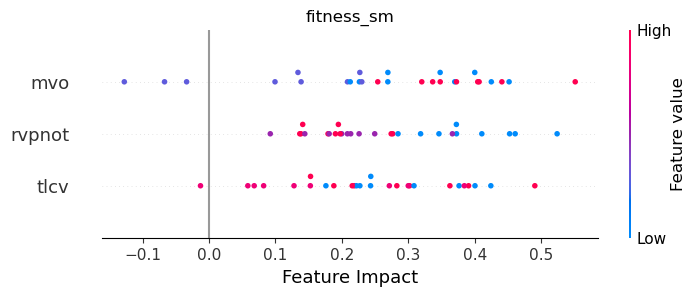

In [36]:
for mine in ["inductive", "imf", "heuristics", "ilp", "sm"]:
    shap.plots.beeswarm(shap_values_obj_dict[f'fitness_'+ mine],show = False,order=order)
    plt.xlabel('Feature Impact')
    plt.title(f'fitness_{mine}')
    plt.show()

precision beeswarm

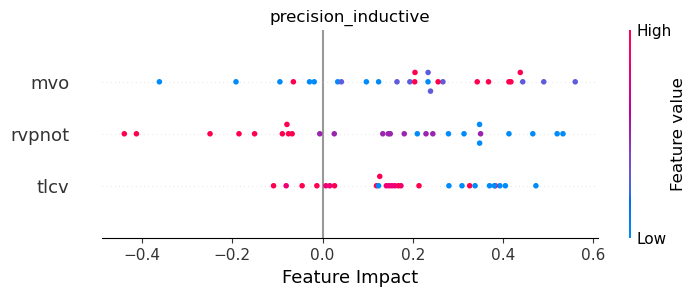

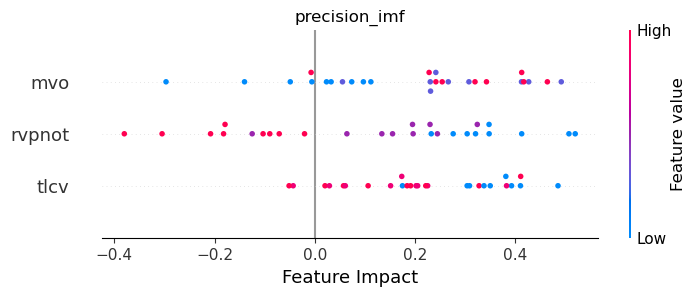

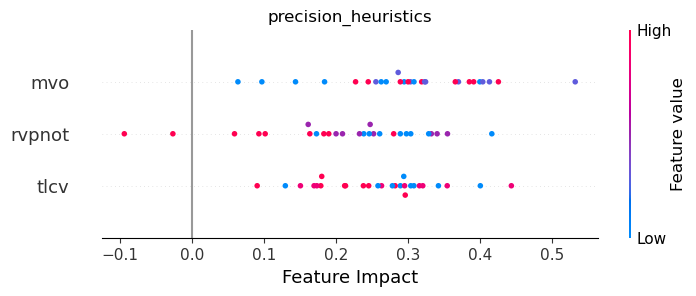

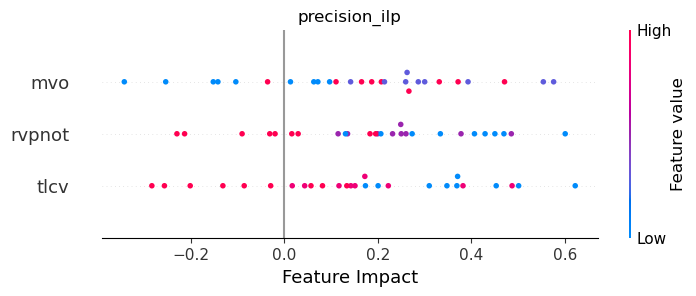

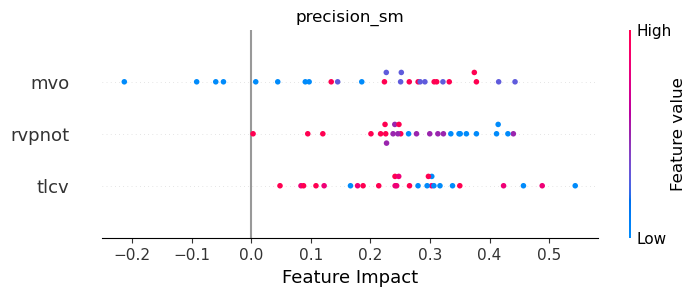

In [37]:
for mine in ["inductive", "imf", "heuristics", "ilp", "sm"]:
    shap.plots.beeswarm(shap_values_obj_dict[f'precision_'+ mine],show = False, order=order)
    plt.xlabel('Feature Impact')
    plt.title(f'precision_{mine}')
    plt.show()

fscore beeswarm

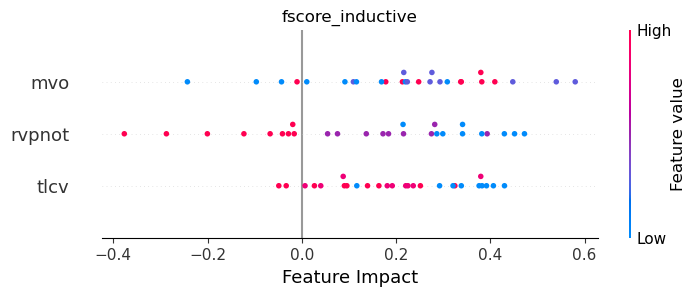

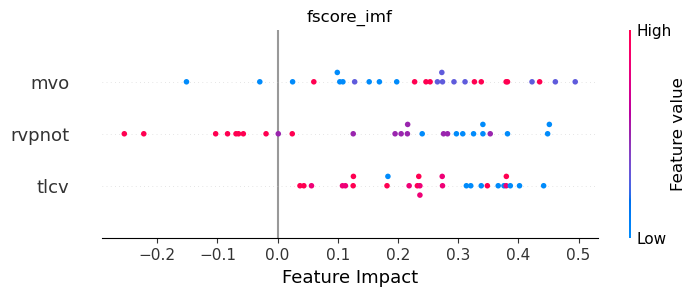

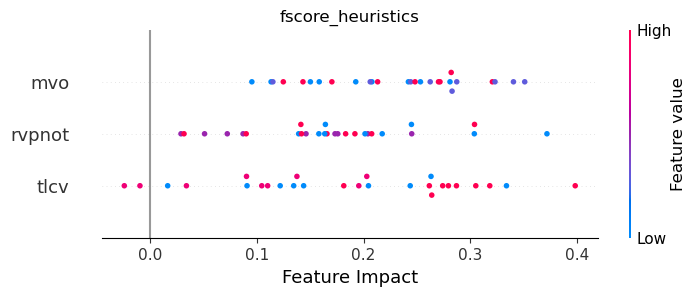

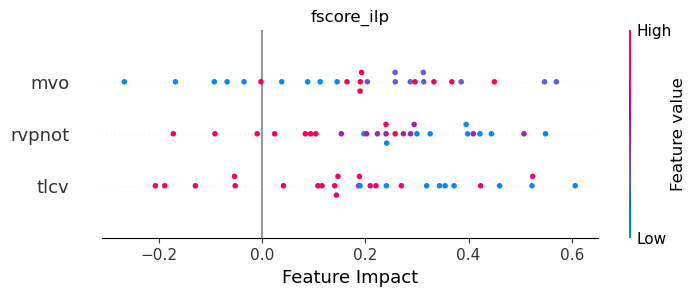

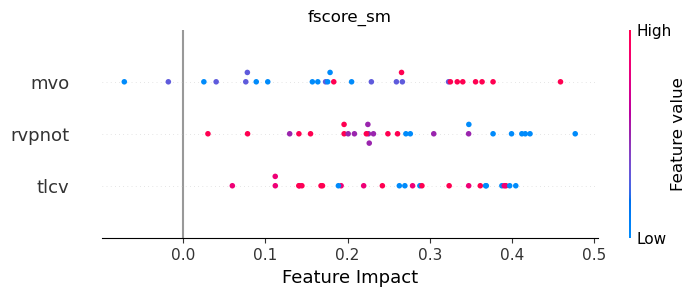

In [38]:
for mine in ["inductive", "imf", "heuristics", "ilp", "sm"]:
    shap.plots.beeswarm(shap_values_obj_dict[f'fscore_'+ mine],show = False, order=order)
    plt.xlabel('Feature Impact')
    plt.title(f'fscore_{mine}')
    plt.show()

size beeswarm

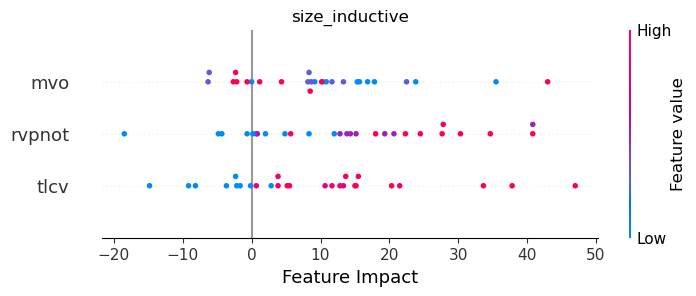

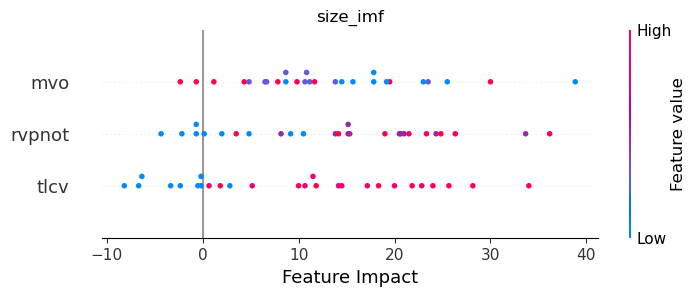

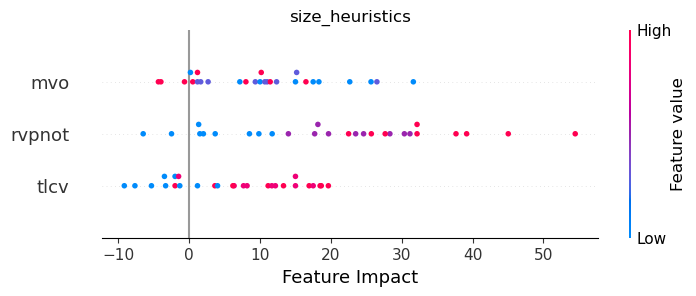

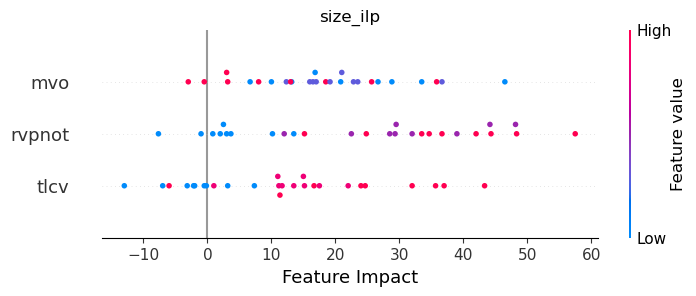

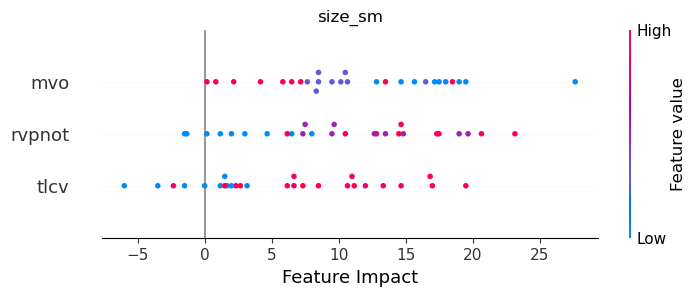

In [39]:
for mine in ["inductive", "imf", "heuristics", "ilp", "sm"]:
    shap.plots.beeswarm(shap_values_obj_dict[f'size_'+ mine],show = False, order=order)
    plt.xlabel('Feature Impact')
    plt.title(f'size_{mine}')
    plt.show()

cfc beeswarm

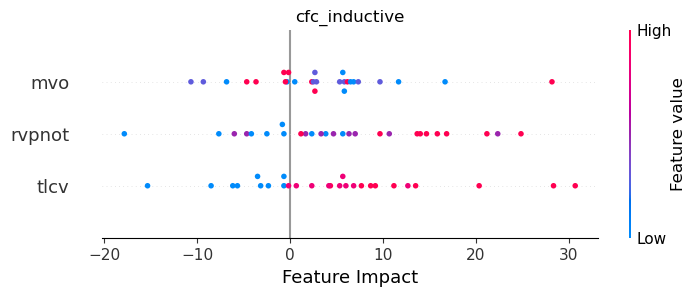

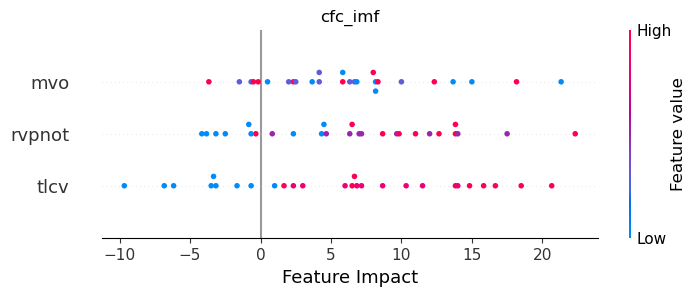

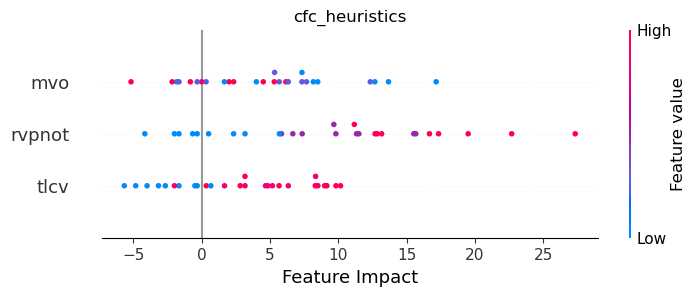

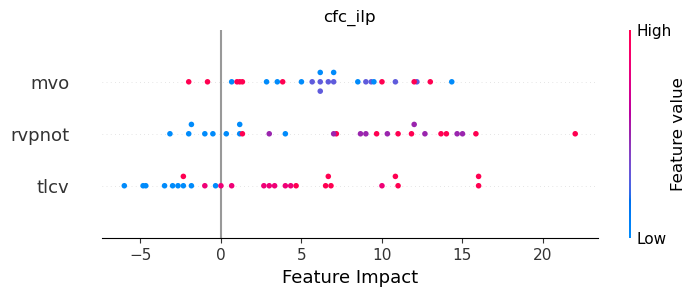

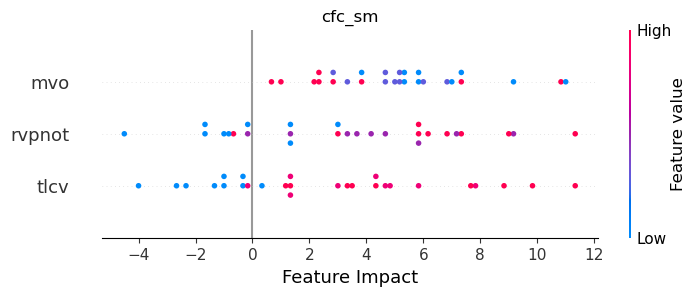

In [40]:
for mine in ["inductive", "imf", "heuristics", "ilp", "sm"]:
    shap.plots.beeswarm(shap_values_obj_dict[f'cfc_'+ mine],show = False, order=order)
    plt.xlabel('Feature Impact')
    plt.title(f'cfc_{mine}')
    plt.show()